In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\HP\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [2]:
df1 = pd.read_csv('ethiopia_tripadvisor_data_model_3.csv')
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"['Amazing', 'location', 'must', 'visit.']"
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"['I', 'do', 'recommend', 'to', 'visit', 'Lalib..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"['A', 'must', 'visit', 'in', 'Ethiopia', '-', ..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"['These', 'churches', 'have', 'to', 'be', 'see..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"['Thanks', 'to', 'our', 'tour', 'organiser', '..."


In [3]:
df1['RH_Split'] = df1['Review Head'].apply(lambda x: x.split(' '))
df1['RB_Split'] = df1['Review Body'].apply(lambda x: x.split(' '))
df1['RT_Split'] = df1['Review Text'].apply(lambda x: x.split(' '))
df1['RB_Sentence1_Split'] = df1['RB_Sentence1'].apply(lambda x: x.split(' '))
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split,RH_Split,RB_Split,RT_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"[Amazing, location, must, visit.]","[Incredible, locations, don't, be, put, off, t...","[Amazing, location, must, visit., This, site, ...","[Incredible, locations, don't, be, put, off, t..."
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!]","[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!, I,..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, ]","[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, A, must, visit, in, E..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"[These, churches, have, to, be, seen, to, be, ...",[Amazing],"[These, churches, have, to, be, seen, to, be, ...","[Amazing, These, churches, have, to, be, seen,..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history]","[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history, Thanks, to, our, tour, org..."


In [4]:
df1['Destination Type'].value_counts()

Landmarks       3803
Museums         2507
Nature/Parks    2001
Name: Destination Type, dtype: int64

### Topic Modelling

In [5]:
# NLTK Stop words
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

test_subset = df1['RH_Split'].values
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for value in test_subset:
    for word in value:
        if (sid.polarity_scores(word)['compound']) >= 0.4:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.4:
            print
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

print('Positive :', len(pos_word_list))       
print('Neutral :', len(neu_word_list))    
print('Negative :', len(neg_word_list))

Positive : 4118
Neutral : 35704
Negative : 326


In [6]:
from nltk.corpus import stopwords

main_stop_words = ['ethiopia', 'ethiopian', 'rock', 'hewn', 'church', 'churches', 'park', 'parks', 'museum', 
                       'museums', 'omo', 'valley', 'mountain', 'mountains', 'addis', 'ababa', 'lucy', 'simien', 
                       'national', 'lalibela', 'gelada', 'haile', 'selassie', 'gondar', 'africa' , 'harar', 
                       'cathedral', 'cathedrals', 'place', 'visit', 'girmay', 
                       '\n', '‘s']
positive_stop_words = list(set(pos_word_list))
negative_stop_words = list(set(neg_word_list))
total_stop_words = main_stop_words + positive_stop_words + negative_stop_words

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(total_stop_words)
print('Stop Words: ', len(stop_words))

Stop Words:  862


In [7]:
# Convert to list
data = df1[df1['Destination Type'] == 'Landmarks'][df1['TextBlob Polarity Head'] > 0]['Review Head'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['It is a real miracle of the world!']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['it', 'is', 'real', 'miracle', 'of', 'the', 'world']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['it', 'is', 'real', 'miracle', 'of', 'the', 'world']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['real', 'world']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('real', 1), ('world', 1)]]

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.126*"experience" + 0.123*"see" + 0.096*"painting" + 0.078*"religious" + '
  '0.048*"visit" + 0.047*"view" + 0.039*"unique" + 0.025*"spectacular" + '
  '0.023*"quite" + 0.020*"magical"'),
 (1,
  '0.145*"site" + 0.070*"important" + 0.063*"really" + 0.053*"historical" + '
  '0.038*"building" + 0.027*"colorful" + 0.025*"construction" + 0.021*"high" + '
  '0.021*"always" + 0.018*"holy"'),
 (2,
  '0.103*"architecture" + 0.094*"walk" + 0.062*"look" + 0.050*"cave" + '
  '0.045*"monastery" + 0.028*"climb" + 0.023*"make" + 0.020*"alone" + '
  '0.020*"unexpected" + 0.018*"natural"'),
 (3,
  '0.096*"stunning" + 0.071*"small" + 0.053*"cool" + 0.045*"example" + '
  '0.044*"mural" + 0.041*"bit" + 0.035*"pay" + 0.032*"absolutely" + '
  '0.032*"ceiling" + 0.030*"photo"'),
 (4,
  '0.184*"history" + 0.117*"guide" + 0.087*"old" + 0.038*"much" + '
  '0.026*"people" + 0.026*"get" + 0.019*"person" + 0.017*"piece" + '
  '0.016*"religion" + 0.016*"lose"'),
 (5,
  '0.088*"go" + 0.073*"incredible" + 0.

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.2703001407341565

Coherence Score:  0.6699898455835933


In [20]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.363256 -0.038234       1        1  17.702145
0     -0.054482  0.216451       2        1  14.422469
4     -0.104041 -0.297706       3        1  13.723977
7     -0.053612  0.074298       4        1  12.126281
6     -0.036614  0.015321       5        1   8.605572
8     -0.028929  0.010381       6        1   8.363418
5     -0.027438  0.008663       7        1   7.988752
3     -0.019820  0.004026       8        1   6.258542
2     -0.020395  0.003309       9        1   6.195742
9     -0.017923  0.003491      10        1   4.613108, topic_info=    Category       Freq          Term      Total  loglift  logprob
61   Default  92.000000         worth  92.000000  30.0000  30.0000
4    Default  76.000000       history  76.000000  29.0000  29.0000
44   Default  77.000000          site  77.000000  28.0000  28.0000
13   Default  44.000000          tour  44.000000  27.0000  27.0000
2    Default  55.000000    experience  55.000000  26.0000  26.0000
15   Default  54.000000           see  54.000000  25.0000  25.0000
11   Default  49.000000         guide  49.000000  24.0000  24.0000
366  Default  42.000000      painting  42.000000  23.0000  23.0000
159  Default  36.000000           old  36.000000  22.0000  22.0000
341  Default  32.000000          city  32.000000  21.0000  21.0000
58   Default  34.000000     religious  34.000000  20.0000  20.0000
112  Default  38.000000     important  38.000000  19.0000  19.0000
60   Default  29.000000          trip  29.000000  18.0000  18.0000
72   Default  19.000000  architecture  19.000000  17.0000  17.0000
54   Default  34.000000        really  34.000000  16.0000  16.0000
163  Default  21.000000            go  21.000000  15.0000  15.0000
59   Default  18.000000      stunning  18.000000  14.0000  14.0000
225  Default  18.000000          walk  18.000000  13.0000  13.0000
49   Default  20.000000      historic  20.000000  12.0000  12.0000
562  Default  20.000000        modern  20.000000  11.0000  11.0000
110  Default  29.000000    historical  29.000000  10.0000  10.0000
6    Default  18.000000           day  18.000000   9.0000   9.0000
3    Default  18.000000    incredible  18.000000   8.0000   8.0000
149  Default  14.000000         small  14.000000   7.0000   7.0000
36   Default  21.000000         visit  21.000000   6.0000   6.0000
265  Default  21.000000          view  21.000000   5.0000   5.0000
55   Default  11.000000       ancient  11.000000   4.0000   4.0000
343  Default  12.000000          look  12.000000   3.0000   3.0000
62   Default  14.000000         local  14.000000   2.0000   2.0000
327  Default  20.000000      building  20.000000   1.0000   1.0000
..       ...        ...           ...        ...      ...      ...
487  Topic10   8.659528          spot   9.362591   2.9982  -2.7761
443  Topic10   5.148805         style   5.851868   2.9483  -3.2960
418  Topic10   4.408455    additional   5.115717   2.9275  -3.4512
396  Topic10   4.185349          huge   4.888423   2.9210  -3.5032
822  Topic10   4.155724         holly   4.875492   2.9165  -3.5103
356  Topic10   4.054045       service   4.757073   2.9164  -3.5350
335  Topic10   4.005053      location   4.708092   2.9145  -3.5472
408  Topic10   3.753858          half   4.456914   2.9046  -3.6120
445  Topic10   2.504002        gonder   3.207041   2.8288  -4.0169
707  Topic10   2.251231   information   2.954256   2.8045  -4.1233
709  Topic10   2.251234    surprising   2.954263   2.8045  -4.1233
56   Topic10   2.002752    mysterious   2.705772   2.7754  -4.2402
14   Topic10   1.965211          main   2.668227   2.7705  -4.2592
69   Topic10   1.946958          wild   2.649972   2.7680  -4.2685
68   Topic10   1.862357         group   2.565382   2.7560  -4.3129
67   Topic10   1.862357      frontier   2.565382   2.7560  -4.3129
619  Topic10   1.725685          axum   2.429140   2.7344  -4.3891
589  Topic10   1.608935   

In [17]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'C:/Users/HP/mallet-2.0.8/'})
mallet_path = r'C:\Users\HP\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [18]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('architecture', 0.13127413127413126),
   ('view', 0.08494208494208494),
   ('small', 0.07335907335907337),
   ('day', 0.05019305019305019),
   ('miss', 0.04633204633204633),
   ('cave', 0.03474903474903475),
   ('drive', 0.03474903474903475),
   ('absolutely', 0.03088803088803089),
   ('spiritual', 0.023166023166023165),
   ('priest', 0.019305019305019305)]),
 (1,
  [('incredible', 0.21011673151750973),
   ('religious', 0.07392996108949416),
   ('time', 0.07003891050583658),
   ('building', 0.0622568093385214),
   ('simply', 0.042801556420233464),
   ('main', 0.0311284046692607),
   ('ancient', 0.027237354085603113),
   ('set', 0.023346303501945526),
   ('culture', 0.023346303501945526),
   ('artifact', 0.019455252918287938)]),
 (2,
  [('tour', 0.14814814814814814),
   ('day', 0.05761316872427984),
   ('cool', 0.0411522633744856),
   ('monastery', 0.037037037037037035),
   ('colorful', 0.03292181069958848),
   ('ceiling', 0.03292181069958848),
   ('historic', 0.032921810699588

2
3
4
5
6
7
8
9
10


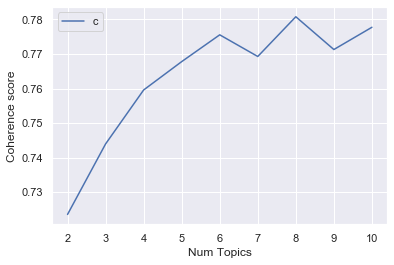

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 2 
limit1 = 11
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7236
Num Topics = 3  has Coherence Value of 0.744
Num Topics = 4  has Coherence Value of 0.7596
Num Topics = 5  has Coherence Value of 0.7678
Num Topics = 6  has Coherence Value of 0.7756
Num Topics = 7  has Coherence Value of 0.7693
Num Topics = 8  has Coherence Value of 0.7808
Num Topics = 9  has Coherence Value of 0.7713
Num Topics = 10  has Coherence Value of 0.7777


In [19]:
# optimal_model = model_list[6] # Number of Topics = 8

optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.238*"site" + 0.059*"historic" + 0.034*"famous" + 0.028*"monastery" + '
  '0.028*"stop" + 0.028*"astonish" + 0.025*"historical" + 0.022*"tour" + '
  '0.019*"highly" + 0.019*"monument"'),
 (1,
  '0.290*"worth" + 0.061*"visit" + 0.041*"magical" + 0.038*"miss" + '
  '0.035*"simply" + 0.032*"absolutely" + 0.026*"structure" + 0.026*"cave" + '
  '0.023*"spiritual" + 0.014*"painting"'),
 (2,
  '0.101*"architecture" + 0.063*"view" + 0.060*"day" + 0.054*"time" + '
  '0.051*"walk" + 0.045*"top" + 0.042*"spectacular" + 0.042*"trip" + '
  '0.027*"city" + 0.027*"unforgettable"'),
 (3,
  '0.235*"experience" + 0.062*"worth" + 0.052*"small" + 0.046*"unique" + '
  '0.033*"cool" + 0.029*"place" + 0.029*"stone" + 0.029*"main" + '
  '0.026*"ceiling" + 0.026*"high"'),
 (4,
  '0.186*"incredible" + 0.153*"guide" + 0.034*"inside" + 0.027*"colorful" + '
  '0.024*"tourist" + 0.024*"day" + 0.020*"significant" + 0.020*"mural" + '
  '0.020*"quiet" + 0.017*"spend"'),
 (5,
  '0.143*"stunning" + 0.090*"paint

In [21]:
optimal_model2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.066600 -0.242895       1        1  12.536973
7     -0.217451  0.192358       2        1  12.525570
6      0.000452 -0.059084       3        1  12.515975
4     -0.111268 -0.236003       4        1  12.501935
1      0.304068  0.089554       5        1  12.497363
0     -0.186006  0.279543       6        1  12.494719
5     -0.019143 -0.098801       7        1  12.472367
3      0.295947  0.075329       8        1  12.455098, topic_info=    Category        Freq          Term       Total  loglift  logprob
61   Default  132.000000         worth  132.000000  30.0000  30.0000
4    Default   95.000000       history   95.000000  29.0000  29.0000
44   Default   89.000000          site   89.000000  28.0000  28.0000
2    Default   88.000000    experience   88.000000  27.0000  27.0000
3    Default   70.000000    incredible   70.000000  26.0000  26.0000
11   Default   57.000000         guide   57.000000  25.0000  25.0000
59   Default   53.000000      stunning   53.000000  24.0000  24.0000
72   Default   38.000000  architecture   38.000000  23.0000  23.0000
13   Default   47.000000          tour   47.000000  22.0000  22.0000
1    Default   33.000000         world   33.000000  21.0000  21.0000
366  Default   39.000000      painting   39.000000  20.0000  20.0000
112  Default   27.000000     important   27.000000  19.0000  19.0000
265  Default   24.000000          view   24.000000  18.0000  18.0000
6    Default   31.000000           day   31.000000  17.0000  17.0000
49   Default   22.000000      historic   22.000000  16.0000  16.0000
36   Default   26.000000         visit   26.000000  15.0000  15.0000
60   Default   40.000000          trip   40.000000  14.0000  14.0000
124  Default   20.000000          time   20.000000  13.0000  13.0000
327  Default   20.000000      building   20.000000  12.0000  12.0000
40   Default   29.000000        unique   29.000000  11.0000  11.0000
110  Default   28.000000    historical   28.000000  10.0000  10.0000
225  Default   19.000000          walk   19.000000   9.0000   9.0000
149  Default   22.000000         small   22.000000   8.0000   8.0000
58   Default   22.000000     religious   22.000000   7.0000   7.0000
107  Default   17.000000        people   17.000000   6.0000   6.0000
39   Default   16.000000           top   16.000000   5.0000   5.0000
55   Default   16.000000       ancient   16.000000   4.0000   4.0000
83   Default   15.000000   spectacular   15.000000   3.0000   3.0000
96   Default   15.000000       magical   15.000000   2.0000   2.0000
138  Default   15.000000          full   15.000000   1.0000   1.0000
..       ...         ...           ...         ...      ...      ...
623   Topic8    3.668371    worthwhile    3.668371   2.0830  -4.6282
219   Topic8    3.668371       totally    3.668371   2.0830  -4.6282
129   Topic8    1.222790     antiquity    1.222790   2.0830  -5.7268
584   Topic8    1.222790    simienview    1.222790   2.0830  -5.7268
585   Topic8    1.222790  professional    1.222790   2.0830  -5.7268
781   Topic8    1.222790      schedule    1.222790   2.0830  -5.7268
595   Topic8    1.222790       situate    1.222790   2.0830  -5.7268
602   Topic8    1.222790      ambiance    1.222790   2.0830  -5.7268
777   Topic8    1.222790    linguistic    1.222790   2.0830  -5.7268
615   Topic8    1.222790      reminder    1.222790   2.0830  -5.7268
726   Topic8    1.222790        female    1.222790   2.0830  -5.7268
634   Topic8    1.222790           buy    1.222790   2.0830  -5.7268
616   Topic8    1.222790       diverse    1.222790   2.0830  -5.7268
186   Topic8    1.222790    understand    1.222790   2.0830  -5.7268
770   Topic8    1.222790       edifice    1.222790   2.0830  -5.7268
38    Topic8   11.005113         place   12.172558   1.9822  -3.5296
149   Topic8   19.564646         small   22.948506   1.9235  -2.9543
105   Topic8    8.559532     expensi

In [22]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.1394,"stunning, painting, people, real, full, modern...",It is a real miracle of the world!
1,1,3.0,0.1394,"experience, worth, small, unique, cool, place,...",Incredible experience
2,2,0.0,0.1250,"site, historic, famous, monastery, stop, aston...",Amazing
3,3,6.0,0.1422,"history, historical, trip, climb, unique, piec...",So much history
4,4,0.0,0.1250,"site, historic, famous, monastery, stop, aston...",Just WoW and Amazing !!
5,5,0.0,0.1250,"site, historic, famous, monastery, stop, aston...",Amazing
6,6,0.0,0.1250,"site, historic, famous, monastery, stop, aston...",wonderful place
7,7,2.0,0.1536,"architecture, view, day, time, walk, top, spec...",Impressive and unexpected - 2 days 1 night
8,8,1.0,0.1368,"worth, visit, magical, miss, simply, absolutel...",One of the Best and economical tour guides in ...
9,9,7.0,0.1400,"tour, world, important, building, religious, a...",Great tour of Lalibela churches with Henok


In [23]:
df_dominant_topic['Dominant_Topic'].value_counts()

0.0    1129
1.0     207
2.0     179
5.0     176
3.0     163
6.0     154
4.0     133
7.0     121
Name: Dominant_Topic, dtype: int64

In [24]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # General Appreciation - 1123
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Visual (Aesthetic, Paintings, etc.) - 200
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Appreciation of History - 182
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # Visual (Aesthetic, Paintings, etc.) - 180
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # General Appreciation - 169
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Appreciation with caveat (Expensive fees) - 162
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # Tour Guide - 115
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # General Appreciation - 131

In [25]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1652,"site, historic, famous, monastery, stop, aston...",Great very important historic site declared as...
1,1.0,0.1775,"worth, visit, magical, miss, simply, absolutel...","Worth visiting, but patience is paramount"
2,2.0,0.1672,"architecture, view, day, time, walk, top, spec...",A town standing on top of history
3,3.0,0.1713,"experience, worth, small, unique, cool, place,...",Awesome Experience But Make Sure You are Physi...
4,4.0,0.1692,"incredible, guide, inside, colorful, tourist, ...","Stunning churches - incredible guide, Memekia!"
5,5.0,0.1713,"stunning, painting, people, real, full, modern...",Exquisite Church Preserving Its Original Const...
6,6.0,0.1672,"history, historical, trip, climb, unique, piec...",50 dollars entrance. Get a good guide (about e...
7,7.0,0.1703,"tour, world, important, building, religious, a...",Great Tour of Lalibela with Mikiyas Tours in E...


In [26]:
sent_topics_sorteddf_mallet['Text'].values

array(['Great very important historic site declared as world heritage site by Unesco',
       'Worth visiting, but patience is paramount',
       'A town standing on top of history',
       'Awesome Experience But Make Sure You are Physically Fit',
       'Stunning churches - incredible guide, Memekia!',
       'Exquisite Church Preserving Its Original Construction',
       '50 dollars entrance. Get a good guide (about extra 15 dollars per person)',
       'Great Tour of Lalibela with Mikiyas Tours in Ethiopia'],
      dtype=object)

In [27]:
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics